# Exploraciones sobre covid-19 en La Paz

> La mortalidad se ha reducido entre todos los grupos de edad. Cuando varias personas enferman en una vivienda suelen contagiarse primero los más jóvenes. Cada ola de contagios tiene un efecto diferente y progresivamente menor sobre la actividad comercial.

In [457]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import ticker, dates, cm, colors
import locale
import geopandas as gpd;
import datetime as dt
from IPython import display
import json
locale.setlocale(locale.LC_TIME, "es_US.UTF8");
plt.style.use('publish/estilo.mplstyle')

## Mortalidad por edad

Como es de esperarse, la mortalidad es superior entre personas mayores 60 años y ha estado decreciendo consistentemente a través de todos los grupos de edad. No es claro qué porciones de esta mejora se deben a más pruebas, vacunas o tratamientos.

In [94]:
def get_mortalidad(rango_size, freq):
    df = pd.read_csv('data/covid_lapaz/2021-12-04.csv', parse_dates=['registro', 'reporte'])
    df = df[(df.edad.notna()) & (df.registro.notna())]
    df['rango_edad'] = pd.cut(df.edad, bins=list(range(0,120, rango_size))).apply(lambda x: x.left)
    df = df[df.registro > '2020-03-01'].groupby([pd.Grouper(key='registro', freq=freq, label='right'), 'rango_edad']).caso.value_counts().reset_index(name='count').pivot_table(index=['registro', 'rango_edad'], columns='caso', values='count').reset_index().fillna(0)
    df['mortalidad'] = (df.fallecido / (df.fallecido + df.positivo + df.recuperado))
    df['registro'] = df.registro.apply(lambda x: x.replace(day=1))
    return df.pivot_table(index='registro', columns='rango_edad', values='mortalidad')

In [480]:
def plot_matrix(mortalidad, edad_min, edad_max, desde, hasta, rango_size):
    
    lincolor = '#88888f'
    dfi = mortalidad.loc[desde:hasta, edad_min:edad_max].replace(0,.001)
    
    f, ax = plt.subplots(1,1,figsize=(14,6))
    im = ax.imshow(dfi.T, cmap='magma', aspect='auto', norm=colors.LogNorm(vmin=.001, vmax=1.), alpha=.8, zorder=1)
    ax.yaxis.set_major_locator(ticker.FixedLocator(list(range(len(dfi.columns)))))
    ax.yaxis.set_major_formatter(ticker.FixedFormatter(['{} - {}'.format(i, i + rango_size) for i in dfi.columns]))
    ax.xaxis.set_major_locator(ticker.FixedLocator(list(range(len(dfi.index)))))
    ax.xaxis.set_major_formatter(ticker.FixedFormatter([i.strftime('%b') for i in dfi.index]))
    for axis, ticks in zip([ax.yaxis, ax.xaxis], [dfi.columns, dfi.index]):
        axis.set_minor_locator(ticker.FixedLocator([i + .485 for i in list(range(len(ticks)))]))
    ax.tick_params(labelcolor=lincolor, labeltop=True, labelbottom=False)
    ax.tick_params(which='major', axis='x')
    ax.grid(which='minor', color='#24242e', linestyle='-', linewidth=.5, alpha=1, zorder=2)
    ax.annotate('Rango de edad', xy=(-.1, .5), xycoords='axes fraction', ha='right', va='center', fontsize=14, color=lincolor, rotation=90)
    ax.annotate('Mortalidad', xy=(1.045, .5), xycoords='axes fraction', ha='right', va='center', fontsize=14, color=lincolor, rotation=270)
    
    cbar = f.colorbar(im, shrink=1., pad=.06, aspect=15)
    cbar.ax.tick_params(labelsize=12)
    cbar.outline.set_linewidth(0)
    labels = cbar.ax.get_yticks()
    cbar.ax.yaxis.set_major_locator(ticker.FixedLocator(labels))
    cbar.ax.set_yticklabels(['{:.0%}'.format(i) for i in labels])
    cbar.ax.tick_params(labelcolor=lincolor)

In [146]:
mortalidad = get_mortalidad(5, 'M')

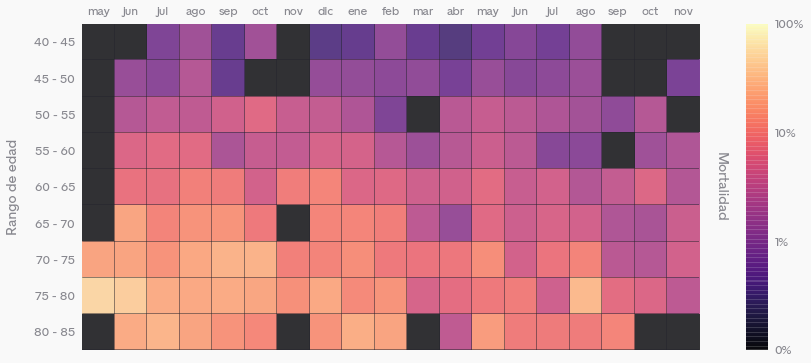

In [481]:
plot_matrix(mortalidad, 40, 80, '2020-05-01', '2021-11-01', 5)

## Dinámicas de contagio

Si la población joven está expuesta a más oportunidades de contagio, ¿existe un patrón en los datos que describa cómo contrae primero la enfermedad y luego contagia a gente mayor? Identifico 841 eventos donde al menos 5 personas contraen la enfermedad en un máximo de 90 días dentro del mismo manzano, con una media de 8.6 casos por evento y un máximo de 85 casos en un mismo evento. En promedio, la edad de los casos sube ligeramente desde el primer caso, pero existe demasiada dispersión para decir algo concluyente.

In [535]:
def get_manzanos():
    manzanos = gpd.read_file('data/poblacion_2020.json')
    manzanos = manzanos[manzanos._municipio == 'La Paz'][['id', 'geometry']]
    return manzanos

def get_casos():
    casos = pd.read_csv('data/covid_lapaz/2021-12-04.csv', parse_dates=['registro', 'reporte'])
    casos = casos[(casos.edad.notna()) & (casos.registro.notna()) & (casos.lon.notna()) & (casos.lat.notna())]
    casos = gpd.GeoDataFrame(casos, geometry=gpd.points_from_xy(casos.lon, casos.lat), crs=manzanos.crs)
    return casos[['id', 'caso', 'sexo', 'edad', 'registro', 'geometry']]

def casos_en_manzanos():
    casos_manzanos = gpd.sjoin(manzanos, casos, op='contains')
    casos_manzanos.columns = ['manzano', 'geometry', 'i2', 'caso', 'resultado', 'sexo', 'edad', 'registro']
    casos_manzanos = casos_manzanos[['caso', 'manzano', 'registro', 'resultado', 'sexo', 'edad', 'geometry']]
    casos_manzanos = casos_manzanos.reset_index(drop=True)
    return casos_manzanos

def get_clusters(casos_manzanos, min_size, max_days):
    n = len(casos_manzanos.manzano.unique())
    for i, (m, manzano_df) in enumerate(casos_manzanos.groupby('manzano')):
        display.clear_output(wait=True)
        print('{}/{}'.format(i, n))
        if len(manzano_df) >= min_size:
            manzano_df = manzano_df.sort_values('registro')
            for ii, caso in manzano_df.iterrows():
                contagio = manzano_df[(manzano_df.registro >= caso.registro) & (manzano_df.registro <= (caso.registro + dt.timedelta(days=max_days)))]
                if len(contagio) >= min_size:
                    if clusters.__contains__(m):
                        if len(contagio) > len(clusters[m]):
                            clusters[m] = contagio['caso'].tolist()
                    else:
                        clusters[m] = contagio['caso'].tolist()

def edad_en_clusters(clusters, casos_manzanos):

    cluster_orden = []
    for cluster in clusters.keys():
        for i, caso in enumerate(clusters[cluster]):
            cluster_orden.append({'orden':i, 'caso':caso, 'cluster':cluster})

    clustero = pd.concat([pd.DataFrame(cluster_orden).set_index('caso'), casos_manzanos.set_index('caso').edad], axis=1).dropna()
    clustero[['orden', 'edad']] = clustero[['orden', 'edad']].astype(int)
    clustero = clustero.pivot_table(index='cluster', columns='orden', values='edad')
    return clustero

def plot_edad_por_orden(clustero):
    
    lincolor = '#88888f'

    spread = pd.concat([clustero.subtract(clustero[0], axis='index').mean().head(10), clustero.subtract(clustero[0], axis='index').std().head(10)], axis=1)
    spread.columns = ['mean', 'std']

    f, ax = plt.subplots(1,1,figsize=(12,8))
    ax.plot(spread['mean'], color='#e0674f', zorder=2, linewidth=3)
    ax.fill_between(spread.index, spread['mean'] - spread['std'], spread['mean'] + spread['std'], color='#e8eaed', zorder=1, alpha=.9, linewidth=0.5)
    ax.grid(axis='y')
    ax.grid(axis='x', alpha=1)
    ax.xaxis.set_major_locator(ticker.IndexLocator(1,0))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(7, prune='both'))
    ax.tick_params(labelcolor=lincolor, labeltop=True, labelbottom=False)
    ax.set_ylim(-30,30)
    ax.set_xlim(0,9.01)
    ax.axhline(0, color='#24242e', linewidth=.5)
    ax.annotate('Años de edad respecto al primer caso', xy=(-.07, .5), xycoords='axes fraction', ha='right', va='center', fontsize=14, color=lincolor, rotation=90)
    ax.annotate('Orden de casos', xy=(.5, 1.07), xycoords='axes fraction', ha='center', va='bottom', fontsize=14, color=lincolor)

In [ ]:
manzanos = get_manzanos()
casos = get_casos()
casos_manzanos = casos_en_manzanos()

clusters = {}
get_clusters(casos_manzanos, 5, 90)
eventos = edad_en_clusters(clusters, casos_manzanos)

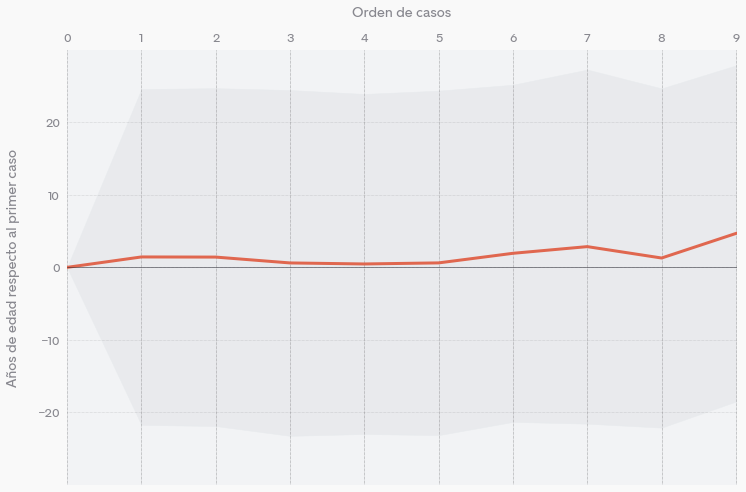

In [536]:
plot_edad_por_orden(eventos)

La línea roja representa la media de años respecto al primer caso y el espacio gris es la desviación estándar. 

## Efecto sobre la actividad económica

Existen demasiados canales mediante los cuales el crecimiento o la expectativa de contagios puede afectar la economía, especialmente de forma negativa. El volumen de registros legales de inmuebles para actividades comerciales es una medida microlocal que debería aproximarse al dinamismo económico del sector comercial, bienes raíces y administración pública. Estimo la trayectoria de esta medida para cada distrito de la ciudad de La Paz desde 6 semanas antes del pico de casos de covid-19 en el distrito, para cada ola de contagios hasta el momento. Encuentro que cada ola coincide con un momento diferente en la actividad económica de distritos y suele tener un efecto negativo. La primera ola frena la aceleración de la actividad económica producto del relajamiento de la cuarentena estricta. La segunda ola coincide con la desaceleración de la economía a fin de año y probablemente retrasa su reinicio. Finalmente, la tercera ola tiene un efecto más leve y heterogeneo, que parece frenar un poco la economía. 

In [538]:
def get_casos():
    casos = pd.read_csv('data/covid_lapaz/2021-12-04.csv', parse_dates=['registro', 'reporte'])
    casos = casos[(casos.registro.notna()) & (casos.distrito.notna())]
    casos['distrito'] = casos['distrito'].astype(int)
    return casos[['id', 'caso', 'sexo', 'edad', 'registro', 'distrito']]

def get_inmuebles():
    inmuebles = gpd.read_file('data/inmueble_actividad_economica.geojson', parse_dates=['fecha_registro', 'fecha_modificacion'])[['id', 'tipo_objeto_tributario', 'fecha_registro', 'distrito']]
    inmuebles = inmuebles[(inmuebles.distrito.notna()) & (inmuebles.fecha_registro.notna())]
    inmuebles['registro'] = pd.to_datetime(pd.to_datetime(inmuebles.fecha_registro).dt.date)
    inmuebles = inmuebles[inmuebles.distrito.isin([str(i) for i in range(0,30)])]
    inmuebles.distrito = inmuebles.distrito.astype(int)
    return inmuebles

def make_inmuebles_casos(freq):
    casos = get_casos()
    inmuebles = get_inmuebles()
    inmuebles_casos = pd.concat([inmuebles.groupby([pd.Grouper(key='registro', freq=freq), 'distrito']).size(), casos[casos.registro > '2020-03-01'].groupby([pd.Grouper(key='registro', freq=freq), 'distrito']).size()], axis=1)
    inmuebles_casos.columns = ['inmuebles', 'casos']
    inmuebles_casos = inmuebles_casos.reset_index().fillna(0)
    inmuebles_casos = inmuebles_casos[inmuebles_casos.registro >= '2020-03-01']
    return [inmuebles_casos.pivot_table(index='registro', columns='distrito', values=col).fillna(0) for col in ['inmuebles', 'casos']]

In [539]:
inmuebles, casos = make_inmuebles_casos(freq='W')

In [537]:
def plot_waves():
    
    lincolor = '#88888f'
    
    waves = {
        1: {'start': '2020-04-01', 'end': '2020-11-01'},
        2: {'start': '2020-11-01', 'end': '2021-04-01'},
        3: {'start': '2021-04-01', 'end': '2021-10-01'},
    }

    f, axs = plt.subplots(1,3,figsize=(15,10), sharey=True)
    plt.subplots_adjust(wspace=.05)

    for ax, wave in zip(axs, range(1,4)):

        wave_start = waves[wave]['start']
        wave_end = waves[wave]['end']

        dfi = []
        for distrito in range(1,23):
            pico = casos.loc[wave_start:wave_end, distrito].sort_values().tail(1).index
            start = casos.index[list(casos.index).index(pico) - 6]
            dfi.append(inmuebles.loc[start:pico.date[0], distrito].reset_index(drop=True))

        dfi = pd.concat(dfi, axis=1)
        dfi = pd.concat([dfi.mean(axis=1), dfi.std(axis=1)], axis=1)
        dfi.columns = ['media', 'desviacion']

        for i, row in dfi.iterrows():
            ax.plot([i] * 2, [row.media - row.desviacion, row.media + row.desviacion], color='#adaaaa', linewidth=.9, zorder=1)

        ax.scatter(dfi.index, dfi.media, color='#e68683', s=50, zorder=2)
        ax.grid(axis='y')
        ax.xaxis.set_major_locator(ticker.FixedLocator(list(range(7))))
        ax.xaxis.set_major_formatter(ticker.FixedFormatter([-6 + i for i in range(7)]))
        
        ax.tick_params(labelcolor=lincolor)
        ax.annotate(wave, xy=(.5, 1.02), xycoords='axes fraction', color=lincolor, ha='center', va='bottom', fontsize=16)
        
    axs[0].annotate('Inmuebles comerciales registrados por semana', xy=(-.16, .5), xycoords='axes fraction', ha='right', va='center', fontsize=14, color=lincolor, rotation=90)
    axs[1].annotate('Semanas antes del pico de la ola', xy=(.5, -.08), xycoords='axes fraction', ha='center', va='top', fontsize=14, color=lincolor)

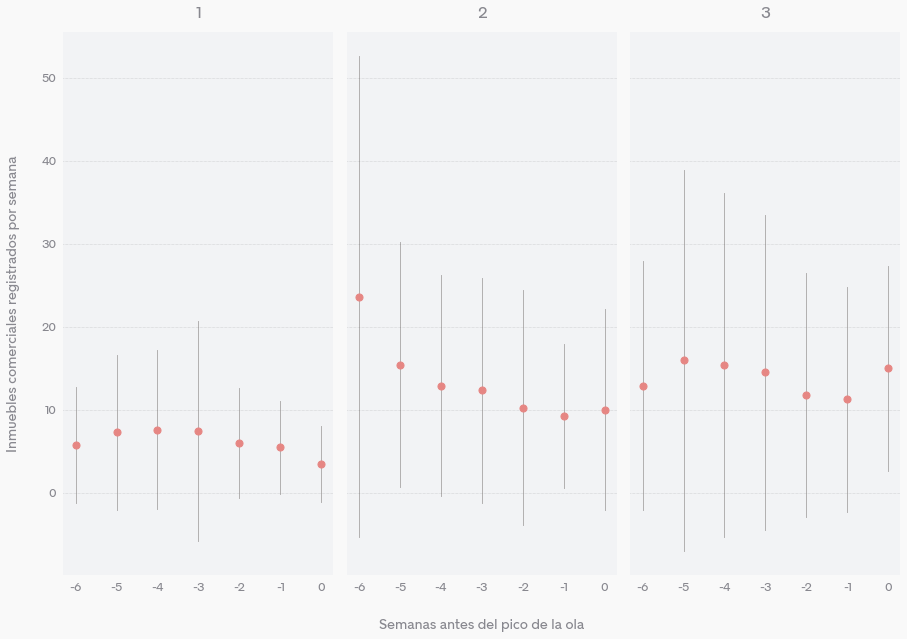

In [540]:
plot_waves()

Cada cuadro representa una ola de contagios, los puntos corresponden a la media de registros inmobiliarios semanales en distritos y las líneas son la desviación estándar.